In [1]:
import json
from langchain_openai import ChatOpenAI # llm model
from langchain.prompts import ChatPromptTemplate # prompt
from langchain_core.output_parsers import StrOutputParser # outputparser
from langchain_experimental.utilities import PythonREPL

In [2]:
with open("config.json", "r") as f: 
    config = json.load(f)

api_key = config.get("api")

model = ChatOpenAI(
    model_name="gpt-4o",
    temperature=0.1,
    openai_api_key=api_key
)

# prompt engineering
template = """Write python code,
        Answer only python code in Markdown format. e.g. 
        ```python
        your python code
        ```"""

prompt = ChatPromptTemplate.from_messages(
    [("system", template), ("human", "{input}")]
)

In [3]:
prompt.format(input="y=x+3")

'System: Write python code,\n        Answer only python code in Markdown format. e.g. \n        ```python\n        your python code\n        ```\nHuman: y=x+3'

In [4]:
def code_output(message) :
    """
    output에서 python markdown sampling
    """
    front,output = message.split("```python")
    return output.split("```")[0]

class CustomStrOutputParser(StrOutputParser):
    def parse(self, output: str):
        print("LLM Output:\n", output)
        return super().parse(output)
    
code_chain = (
    prompt | model | CustomStrOutputParser() | PythonREPL().run
)

Python REPL can execute arbitrary code. Use with caution.


LLM Output:
 ```python
import matplotlib.pyplot as plt
import numpy as np

# Define the range for x
x = np.linspace(-10, 10, 400)

# Define the function y = x^2
y = x**2

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='y = x^2')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of y = x^2')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

# Show the plot
plt.show()
```


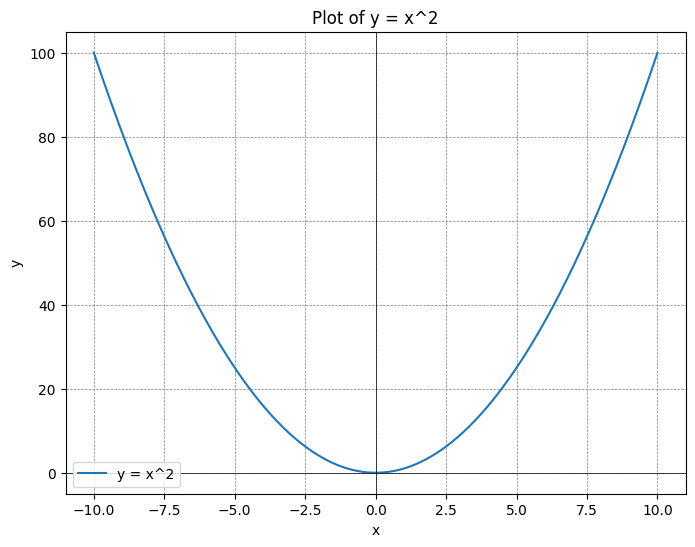

''

In [5]:
code_chain.invoke({"input": "draw y=x^2"})

# Image -> Code

In [6]:
import base64
from langchain_openai import ChatOpenAI # llm model
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import (
    RunnablePassthrough,
    RunnableLambda,
    RunnableParallel,
    chain
)

In [ ]:
vision_model = model

def encode_image(path) :
    with open(path, "rb") as f :
        img = base64.b64encode(f.read()).decode("utf-8")
    return f"data:image/jped;base64,{img}"

def vision_chain(input) :
    img_path, url = str(input["img_path"]), bool(input["url"])

    img_url = img_path if url else encode_image(img_path)

    system_message = SystemMessage(
        content=[
            """Look at the image and write a matplotlib python code that draws the corresponding graph,
                Answer only python code in Markdown format. e.g. 
                ```python
                your python code
            ```"""
        ]
    )
    vision_message = HumanMessage(
        content=[
            {"type" : "text", "text" : "Can you write a python code to draw this plot?"},
            {
                "type": "ima_url",
                "ima_url": {
                    "url": img_url,
                    "detail": "auto"
                }
            }
        ]
    )
    output = vision_model.invoke([system_message, vision_message])
    return output.content

In [9]:
img_chain = (
    vision_chain | CustomStrOutputParser() | code_output | PythonREPL().run
)

In [14]:
img_path = "./img/tmp.jpg"

img_chain.invoke({"img_path": img_path, "url": False})

TypeError: SystemMessage.__init__() missing 1 required positional argument: 'content'